In [2]:
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.formula.api as sm
from sklearn import linear_model, preprocessing
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, mean_absolute_error
import time

In [88]:
pd.set_option('display.max_columns', 500)

In [1]:
import time
def timeit(method):
    '''A time decorator to time other functions.'''
    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()
        if 'log_time' in kw:
            name = kw.get('log_name', method.__name__.upper())
            kw['log_time'][name] = int((te - ts) * 1000)
        else:
            print ('%r  %2.2f ms' %(method.__name__, (te - ts) * 1000))
        return result
    return timed

In [2]:
import pickle
def save_obj(obj, name ):
    with open('obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        
def append_obj(obj,name):
    with open('obj/'+ name + '.pkl', 'ab') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        
def load_obj(name ):
    if name.endswith('.pkl'):
        with open('obj/' + name, 'rb') as f:
            return pickle.load(f)
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

### Train&Predict Class

Class that reads in a cleaned df a set of xCols and a target feature. Has methods for MSE, MAE and Variance

In [1]:
class LinearTrainPredict:
    
    def __init__ (self, df, xCol, y, name=""):
        self.df = df
        self.xCol = xCol
        self.y = y
        self.__split = int(self.df.shape[0]*0.7)
        self.__X = pd.get_dummies(self.df[self.Xcol],drop_first=True)
        self.__xTrain, self.__xTest = self.__X[:self.__split], self.__X[self.__split:]
        self.__yTrain, self.__yTest = self.df[self.y][:self.__split], self.df[self.y][self.__split:]
        self.__regr = linear_model.LinearRegression()
        if name == ""
            pass
        else:
            with open('obj/'+ name + '.pkl', 'wb') as f:
                pickle.dump(self.__regr, f, pickle.HIGHEST_PROTOCOL)
        self.__regr.fit(self.__xTrain, self.__yTrain)
        self.yPred = self.__regr.predict(self.__xTest)
        
    def mSqErr(self):
        return mean_squared_error(self.__yTest,self.yPred)
        
    def mAbsErr(self):
        return mean_absolute_error(self.__yTest,self.yPred)
    
    def varScore(self):
        return r2_score(self.__yTest,self.yPred)

## Cleaning Dfs

Some fucntions that clean dfs and adds features such as weekday and month integers

In [3]:
#def dateManipulations(df, dateCol, arrCol, m=False, d=False, weekendSplit=False):
def dateManipulations(df, d=False, weekendSplit=False):
    
    
    # ? Duplicate with the weatherInfo function here...
    #df.dateCol = df.dateCol.astype('datetime64[ns]')
    #df['datetime'] = df.dateCol + pd.to_timedelta(df.arrCol, unit = 's')
    # ?
    
    '''
    #We don't use month as a feature anymore, this block can be deleted.
    
    #if m == False:
    #Suggest change to:
    if not m:
        pass
    
    #Suggest change to:
    elif m:
    #elif m == True:
        df['month'] = df.dateCol.map(lambda x: x.month)
    else:
        return 'Error in month input, must be True or False!'
    
    
    #same as above.
    #if d == False:
    if not d:
        pass
    
    #elif d == True:
    elif d:
        df['weekday'] = df.dateCol.dt.dayofweek
    else:
        return 'Error in day input, must be True or False!'
    '''
    #suggest change to:
    if weekendSplit and d:
    #if weekendSplit == True && d == True:
        
        #df['m2f'] = np.where((df.weekday ==0) & (df.weekday ==1) & (df.weekday ==2) & (df.weekday ==3) & (df.weekday ==4),1,0)
        #Suggest change to:
        df['m2f'] = np.where(df.weekday <= 4, 1,0)
        df['sat'] = np.where((df.weekday == 5),1,0)
        
    #same above
    elif not weekendSplit:
    #elif weekendSplit == False:
        pass
    #elif weekendSplit == True && d == False:
    elif weekendSplit and not d:
        return 'Error, must have weekday column for weekend split'
    else:
        return 'Error in weekend split input, must be True or False!'
    return df

In [4]:
def addPeakHours(df, timeOfDayCol):
    df['em'] = np.where((df[timeOfDayCol] > 14400) & (df[timeOfDayCol] <=  25200),1,0)
    df['mp'] = np.where((df[timeOfDayCol] > 25200) & (df[timeOfDayCol] <=  36000),1,0)
    df['lm'] = np.where((df[timeOfDayCol] > 36000) & (df[timeOfDayCol] <=  46800),1,0)
    df['md'] = np.where((df[timeOfDayCol] > 46800) & (df[timeOfDayCol] <=  47600),1,0)
    df['ap'] = np.where((df[timeOfDayCol] > 47600) & (df[timeOfDayCol] <=  68400),1,0)
    df['ev'] = np.where((df[timeOfDayCol] > 68400) & (df[timeOfDayCol] <=  79200),1,0)
    df['ln'] = np.where((df[timeOfDayCol] > 79200) & (df[timeOfDayCol] <=  90000),1,0)
    return df

In [49]:
def addStartTime(df):
    '''This function will take a dataframe, extract the start time of each trip then append it to  each row.'''
    
    startTime = df.loc[df.progrnumber == 1]
    startTime = startTime.drop(['progrnumber', 'stopid', 'plannedtime','actual_arr', 'datetime', 'weekday', 'rain', 'temp'],1)
    startTime.columns = ['dayofservice','tripid','tripStart']
    result = pd.merge(df,startTime,on=['dayofservice','tripid'])
    #print("result columns:",result.columns)
    result['tripTravelTime'] = result.actual_arr - result.tripStart
    result = result.loc[result.tripTravelTime > 0]
    return result

### Weather Function
Basic function that reads in the weather csv, formats it and merges it with supplied data, returning the merged datframe

### I cleaned this function a little bit. -Wang

In [63]:
weather = pd.read_csv('CleanedWeather2016_17C.csv')
weather.head()

,datetime,rain,temp
0,2016-01-01 00:00:00,0.0,1.2
1,2016-01-01 01:00:00,0.0,1.5
2,2016-01-01 02:00:00,0.0,-0.2
3,2016-01-01 03:00:00,0.0,-0.7
4,2016-01-01 04:00:00,0.0,-0.3


In [64]:
weather.datetime.dtype

dtype('O')

In [6]:
def weatherInfo(data):
    '''Add weather information (temp, precipitation) to the dataframe.'''
    
    weather = pd.read_csv('CleanedWeather2016_17C.csv')#,index_col=0)
    weather.datetime = weather.datetime.astype('datetime64[ns]')
    
    data.dayofservice = data.dayofservice.astype('datetime64[ns]')
    data['datetime'] = data.dayofservice + pd.to_timedelta(data.actual_arr,unit='s')
    data['weekday'] = data.dayofservice.dt.dayofweek
    data = data.sort_values('datetime')
    #data = data.reset_index()
    data[['tripid','progrnumber']] = data[['tripid','progrnumber']].astype('int')
    df = pd.merge_asof(data,weather,on='datetime',tolerance=pd.Timedelta('1h'))
    
    return df

In [7]:
def addUCDTerm(df):
    '''Add historical UCD Term for first half years of 2016 and 2017.'''
    df['ucdSchoolTerm'] = np.where(((df['dayofservice'] >= '2016-01-25') & (df['dayofservice'] <= '2016-04-29'))
                                     | ((df['dayofservice'] >= '2016-05-09') & (df['dayofservice'] <= '2016-05-21'))
                                     | ((df['dayofservice'] >= '2017-01-23') & (df['dayofservice'] <= '2016-04-28'))
                                     | ((df['dayofservice'] >= '2016-05-08') & (df['dayofservice'] <= '2016-05-19'))
                                     ,1,0)
    return df

In [46]:
'102_10l'.split('_')

['102', '10l']

In [53]:
import fnmatch, os
for file in os.listdir('obj/stopDicts/'):
    #print(file)
    if fnmatch.fnmatch(file, '39A_767_7162_*'):
        print(file)

39A_767_7162_Ongar.pkl


In [12]:
import fnmatch, os
import numpy as np
import pandas as pd
@timeit
def dataPreparation(file):
    '''
    Prepare the data and return the prepared dataframe.
    Will have columns:
    ['progrnumber','plannedtime','rain','weekday','shape_dist_traveled','em','mp','lm','md','ap','ev','ln','temp','m2f','sat',
    'ucdSchoolTerm']
    '''
    
    df = pd.read_csv(file,names=['dayofservice','tripid','progrnumber','stopid','plannedtime','actual_arr','actual_dep'])
    #print("Read in:",df.columns)
    
    line = str(file.split('/')[-1].split('_')[0])
    #print("Line:",line)
    if not df.loc[df.progrnumber == 1].empty:
        startStop = str(df.loc[df.progrnumber == 1,'stopid'].values[0])
        #print("startStop:",startStop)
        
        #dfMerged.loc[dfMerged.progrnumber.idxmax(),'stopid']
        endStop = str(df.loc[df.progrnumber.idxmax(),'stopid'])
        #print("endStop:",endStop)

        #add weather and initial cleaning.
        df = weatherInfo(df)

        #print("After weatherInfo:",df.columns)
        #add start time
        df = addStartTime(df)

        #add distance
        #read in specific pkl in
        for file in os.listdir('obj/stopDicts/'):
        #print(file)
            if fnmatch.fnmatch(file, line+'_'+startStop+'_'+ endStop+ '_*'):
                disDict = load_obj('stopDicts/'+file)
                disdf = pd.DataFrame.from_dict(disDict,orient='index',columns=['distance'])
                df = pd.merge(df,disdf,left_on=['stopid'],right_index=True)
                

                #add period
                df = addPeakHours(df,'actual_arr')

                #add weekday
                df = dateManipulations(df,True,True)

                #add UCD Term
                df = addUCDTerm(df)
                
                identifier = (line, startStop, endStop)
    
                return df, identifier

In [87]:
testdf = dataPreparation('Test/leavetimes/39A_41l')
testdf.head()

'dataPreparation'  1240.78 ms


,dayofservice,tripid,progrnumber,stopid,plannedtime,actual_arr,actual_dep,datetime,weekday,rain,...,em,mp,lm,md,ap,ev,ln,m2f,sat,ucdSchoolTerm
0,2016-01-09,2784381,1,767,83700,83586,83586,2016-01-09 23:13:06,5,4.4,...,0,0,0,0,0,0,1,0,1,0
25,2016-01-09,2784382,1,767,84600,84561,84561,2016-01-09 23:29:21,5,4.4,...,0,0,0,0,0,0,1,0,1,0
49,2016-01-16,2784381,1,767,83700,83392,83392,2016-01-16 23:09:52,5,0.1,...,0,0,0,0,0,0,1,0,1,0
50,2016-01-16,2784382,1,767,84600,84570,84570,2016-01-16 23:29:30,5,0.1,...,0,0,0,0,0,0,1,0,1,0
75,2016-01-23,2784381,1,767,83700,83685,83685,2016-01-23 23:14:45,5,0.0,...,0,0,0,0,0,0,1,0,1,0


In [51]:
testDict = load_obj('stopDicts/39A_767_328_Aston Quay')
testDict

{767: 0.0,
 768: 657.287066064875,
 769: 985.330520927881,
 770: 1429.24894221461,
 771: 1620.44696377974,
 772: 2127.48709498295,
 773: 3434.8578642479997,
 774: 3677.18821727873,
 775: 4001.74363072419,
 776: 4285.13185337461,
 777: 4493.83259606615,
 779: 4740.48732233394,
 780: 5009.04830237385,
 781: 5193.6587029476,
 782: 5357.09815442135,
 783: 5606.069766801032,
 784: 5776.637949866071,
 785: 6055.606335357479,
 786: 6545.589502681712,
 793: 7269.64182312836,
 7586: 7835.15763393275,
 7587: 8467.10980025078,
 7588: 8530.04627616102,
 328: 9243.322928124291}

In [90]:
testdf

,dayofservice,tripid,progrnumber,stopid,plannedtime,actual_arr,actual_dep,datetime,weekday,rain,temp,tripStart,tripTravelTime,distance,em,mp,lm,md,ap,ev,ln,m2f,sat,ucdSchoolTerm
0,2016-01-09,2784381,1,767,83700,83586,83586,2016-01-09 23:13:06,5,4.4,3.0,83586,0,0.000000,0,0,0,0,0,0,1,0,1,0
25,2016-01-09,2784382,1,767,84600,84561,84561,2016-01-09 23:29:21,5,4.4,3.0,84561,0,0.000000,0,0,0,0,0,0,1,0,1,0
49,2016-01-16,2784381,1,767,83700,83392,83392,2016-01-16 23:09:52,5,0.1,4.8,83392,0,0.000000,0,0,0,0,0,0,1,0,1,0
50,2016-01-16,2784382,1,767,84600,84570,84570,2016-01-16 23:29:30,5,0.1,4.8,84570,0,0.000000,0,0,0,0,0,0,1,0,1,0
75,2016-01-23,2784381,1,767,83700,83685,83685,2016-01-23 23:14:45,5,0.0,12.4,83685,0,0.000000,0,0,0,0,0,0,1,0,1,0
100,2016-01-30,2784381,1,767,83700,83635,83635,2016-01-30 23:13:55,5,0.0,2.8,83635,0,0.000000,0,0,0,0,0,0,1,0,1,1
125,2016-01-30,2784382,1,767,84600,84553,84553,2016-01-30 23:29:13,5,0.0,2.8,84553,0,0.000000,0,0,0,0,0,0,1,0,1,1
149,2016-02-02,2818069,1,767,84600,84613,84613,2016-02-02 23:30:13,1,0.0,1.9,84613,0,0.000000,0,0,0,0,0,0,1,1,0,1
170,2016-02-05,2818069,1,767,84600,84616,84616,2016-02-05 23:30:16,4,0.0,3.4,84616,0,0.000000,0,0,0,0,0,0,1,1,0,1
192,2016-02-06,2822742,1,767,83700,83683,83683,2016-02-06 23:14:43,5,0.0,3.7,83683,0,0.000000,0,0,0,0,0,0,1,0,1,1


In [53]:
testdf.loc[testdf.distance.isnull()]

,dayofservice,tripid,progrnumber,stopid,plannedtime,actual_arr,actual_dep,datetime,weekday,rain,...,em,mp,lm,md,ap,ev,ln,m2f,sat,ucdSchoolTerm


## Route Manipulation functions

Functions that uses stop_times.txt to generate features and a route Dictionary that will be used with model prediction

# <font color='red'> Only run it once</font>

In [8]:
#Some of the work is once off, I suggest do it once not do it everytime we load in the txt.
import pandas as pd
stoptime = pd.read_csv('stop_times.txt')
#Only look at the rows for certain route.
stoptime['line'] = stoptime.trip_id.str.split('-').str[1]
stoptime = stoptime[stoptime.stop_id.str.contains(':') == False]
stoptime['stopid'] = stoptime.stop_id.str.slice(8,)
stoptime.stopid = stoptime['stopid'].astype('int64')
stoptime.to_csv('stop_timesC',index=False)

In [10]:
stoptime = pd.read_csv('stop_timesC')
#stoptime.dtypes
stoptime.head()

/home/student/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,line,stopid
0,3643.y102m.60-1-d12-1.1.O,15:40:00,15:40:00,8240DB000226,1,Sandymount,0,0,0.000000,1,226
1,3643.y102m.60-1-d12-1.1.O,15:40:47,15:40:47,8240DB000228,2,Sandymount,0,0,261.136188,1,228
2,3643.y102m.60-1-d12-1.1.O,15:41:26,15:41:26,8240DB000229,3,Sandymount,0,0,484.925289,1,229
3,3643.y102m.60-1-d12-1.1.O,15:42:30,15:42:30,8240DB000227,4,Sandymount,0,0,836.995679,1,227
4,3643.y102m.60-1-d12-1.1.O,15:43:09,15:43:09,8240DB000230,5,Sandymount,0,0,1066.461783,1,230


In [11]:
stoptime['tripmark'] = stoptime.trip_id.str.split('.').str[3]
stoptime.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,line,stopid,tripmark
0,3643.y102m.60-1-d12-1.1.O,15:40:00,15:40:00,8240DB000226,1,Sandymount,0,0,0.000000,1,226,1
1,3643.y102m.60-1-d12-1.1.O,15:40:47,15:40:47,8240DB000228,2,Sandymount,0,0,261.136188,1,228,1
2,3643.y102m.60-1-d12-1.1.O,15:41:26,15:41:26,8240DB000229,3,Sandymount,0,0,484.925289,1,229,1
3,3643.y102m.60-1-d12-1.1.O,15:42:30,15:42:30,8240DB000227,4,Sandymount,0,0,836.995679,1,227,1
4,3643.y102m.60-1-d12-1.1.O,15:43:09,15:43:09,8240DB000230,5,Sandymount,0,0,1066.461783,1,230,1


In [14]:
stoptime[['stop_sequence','stop_headsign','shape_dist_traveled','line','stopid','tripmark']].drop_duplicates().to_csv('stop_timeCC',index=False)

In [ ]:
'''
I notice a situation that you cannot just use get unique to get all the unique route. This is because there are more than one
route for a bus line + direction. E.g.:
39aO has three combination, 
1. start from UCD(767), go to Ongar
2. start from UCD(767), go to Aston
3. start from Aston(328), go to Ongar.
Base on this kind of situation, I suggest we name route as 39a_767_7162_Ongar (busline+startstopid+endstopid+destinationStop).
This will guarantee we have all the routes and it would be clean and without dupilication.
'''

In [30]:
d = load_obj('stopDicts/39A_767_ Ongar')
d

{767: 0.0,
 768: 657.287066064875,
 769: 985.330520927881,
 770: 1429.24894221461,
 771: 1620.44696377974,
 772: 2127.48709498295,
 773: 3434.8578642479997,
 774: 3677.18821727873,
 775: 4001.74363072419,
 776: 4285.13185337461,
 777: 4493.83259606615,
 779: 4740.48732233394,
 780: 5009.04830237385,
 781: 5193.6587029476,
 782: 5357.09815442135,
 783: 5606.069766801032,
 784: 5776.637949866071,
 785: 6055.606335357479,
 786: 6545.589502681712,
 793: 7269.64182312836,
 7586: 7835.15763393275,
 7587: 8467.10980025078,
 7588: 8530.04627616102,
 328: 9243.322928124291,
 1443: 9826.568859010358,
 1444: 10107.2418629801,
 1445: 10417.1497368751,
 1647: 10939.5178555804,
 1648: 11272.5213698264,
 1649: 11469.3056185517,
 1911: 11995.4996735001,
 1913: 12337.7290265695,
 1914: 12592.8159362723,
 1805: 12806.0519246444,
 1806: 13196.947965981299,
 1660: 13713.2410577792,
 1661: 13997.7195279663,
 1662: 14322.374320031799,
 1664: 14788.0353517777,
 1665: 15079.2139210518,
 1666: 15297.9786348426

In [59]:
pd.DataFrame.from_dict(d,orient='index',columns=['distance'])

,distance
767,0.000000
768,657.287066
769,985.330521
770,1429.248942
771,1620.446964
772,2127.487095
773,3434.857864
774,3677.188217
775,4001.743631
776,4285.131853


In [47]:
#Based on the discussion above, I changed this function into a function that run once and split all the routes into pickle file
# for later consideration:
#https://stackoverflow.com/questions/16497115/python-pickle-vs-sql-efficiency
#security issue? efficiency issue?...
@timeit
def getStops(file):
    
    '''get stops for a certain route from GTFS file.'''
    
    stoptime = pd.read_csv(file)
    '''
    #stoptime['line'] = stoptime.trip_id.str.split('-').str[1]
    #stoptime = stoptime[stoptime.stop_id.str.contains(':') == False]
    #stoptime['stopid'] = stoptime.stop_id.str.slice(8,)
    #stoptime.stopid = stoptime['stopid'].astype('int64')
    
    if outbound == True:
        routeDf = stoptime.loc[(stoptime.line == route) & (stoptime.trip_id.str.split('.').str[4]=='O')]
    elif outbound == False:
        routeDf = stoptime.loc[(stoptime.line == route) & (stoptime.trip_id.str.split('.').str[4]=='I')]
    else:
        return 'Error outbound must be True or False!'
    
    #Now there are many duplicate in the df, get unique.
    
    return routeDf[['stop_sequence','shape_dist_traveled', 'stopid']]
    
    header = ['stop_sequence','stop_headsign','shape_dist_traveled','line','stopid','tripmark']
    '''
    for line in stoptime.line.unique():
        for tm in stoptime.tripmark.unique():
            df = stoptime.loc[(stoptime.line == line) & (stoptime.tripmark == tm)]
            #print(df)
            if not df.empty and not df.loc[df.stop_sequence==1,'stopid'].empty:
                #IndexError: index 0 is out of bounds for axis 0 with size 0
                start = str(df.loc[df.stop_sequence==1,'stopid'].values[0]).strip()
                dest = str(df.loc[df.stop_sequence==1,'stop_headsign'].values[0]).strip()
                end = str(df.loc[df.stop_sequence.idxmax(),'stopid']).strip()
                save_obj(df[['stopid','shape_dist_traveled']].set_index('stopid')['shape_dist_traveled'].to_dict(), \
                         'stopDicts/'+str(line)+'_'+start+'_'+ end +'_'+ dest)

In [48]:
getStops('stop_timeCC')

'getStops'  349834.00 ms


# <font color='red'> Only run it once END</font>

In [7]:
def createStopDict(routeDf, name):
    stops = routeDf[['stop_sequence','stopid']]
    stops = stops.reset_index(drop = True)
    stops = stops.sort_values('stop_sequence')
    with open('obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(stops.stopid.tolist(), f, pickle.HIGHEST_PROTOCOL)
    return

In [3]:
def checkstopSeq(routeDf):
    if routeDf.stopSeq.iloc[0] != 1:
        print('Starting stop is not 1')
        return False
    else:
        for i in routeDf.stopSeq:
            if routeDf.stopSeq.iloc[i+1] - routeDf.stopSeq.iloc[i] == 1:
                pass
                if routeDf.stopSeq.iloc[i+1] == routeDf.stopSeq.iloc[-1]:
                    break
            else:
                return False
            if routeDf.stopSeq.is_monotonic_increasing == True:
                return True
            elif routeDf.stopSeq.is_monotonic_increasing == False:
                return False
            else:
                return 'Error in monotonic method'

In [ ]:
#Now we have the dictionary pickle that contains stopid and distance, we can use this to add features.


# The functions for data preparation is ready above, time to build functions to train models. :)

In [57]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
import os
@timeit
def prepareAndTrain(df, identifier, Xcol=['progrnumber','plannedtime','rain','weekday','distance','em','mp','lm','md','ap','ev',
                                          'ln','temp','m2f','sat','ucdSchoolTerm'], y='tripTravelTime', split=0.7):
    '''
    This function will take a dataframe, Prepare it for a neural network model.
    Export scaler file for later use.
    Xcol: A list of columns to train model
    y: target feature
    split: split percentage. By default 0.7/0.3
    train neural network model
    evaluate it.
    '''
        #df.sample(frac=1)
    df = df.loc[df.tripTravelTime > 0].sample(frac=1)
    X = df[Xcol]
    split = int(df.shape[0]*split)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = df[y][:split], df[y][split:]
    scaler = StandardScaler() 
    scaler.fit(X_train)

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    regr = MLPRegressor()
    regr.fit(X_train, y_train)
    
    y_pred = regr.predict(X_test)
    print('MAE:',mean_absolute_error(y_test, y_pred))
    
    if mean_absolute_error(y_test, y_pred) <= 300:
        #if not os.path.isfile('obj/scalers/'+identifier[0]+'_'+identifier[1]+'_'+identifier[2]+'_scaler'): 
        #Model's MAE smaller than 5mins
        
        #How to name it?
        save_obj(scaler,'scalers/'+identifier[0]+'_'+identifier[1]+'_'+identifier[2]+'_scaler')
        save_obj(regr,'models/'+identifier[0]+'_'+identifier[1]+'_'+identifier[2]+'_model')
    else:
        log = "Unqualified route:"+str(identifier)
        print(log)
        append_obj(identifier,'unqualifiedlog')

In [55]:
testdf, id = dataPreparation('Test/leavetimes/39A_40l')

'dataPreparation'  268912.01 ms


In [56]:
testdf

,dayofservice,tripid,progrnumber,stopid,plannedtime,actual_arr,actual_dep,datetime,weekday,rain,...,em,mp,lm,md,ap,ev,ln,m2f,sat,ucdSchoolTerm
1,2016-01-09,2784478,2,768,23543,23486,23486,2016-01-09 06:31:26,5,0.0,...,1,0,0,0,0,0,0,0,1,0
74,2016-01-09,2784522,2,768,24443,24463,24479,2016-01-09 06:47:43,5,0.0,...,1,0,0,0,0,0,0,0,1,0
147,2016-01-09,2784527,2,768,25304,25293,25293,2016-01-09 07:01:33,5,0.4,...,0,1,0,0,0,0,0,0,1,0
220,2016-01-09,2784397,2,768,27104,26804,26814,2016-01-09 07:26:44,5,0.4,...,0,1,0,0,0,0,0,0,1,0
293,2016-01-09,2784404,2,768,28004,28089,28089,2016-01-09 07:48:09,5,0.4,...,0,1,0,0,0,0,0,0,1,0
366,2016-01-09,2784532,2,768,28925,28892,28892,2016-01-09 08:01:32,5,1.1,...,0,1,0,0,0,0,0,0,1,0
438,2016-01-09,2784574,2,768,29825,29826,29826,2016-01-09 08:17:06,5,1.1,...,0,1,0,0,0,0,0,0,1,0
511,2016-01-09,2784542,2,768,30725,30697,30697,2016-01-09 08:31:37,5,1.1,...,0,1,0,0,0,0,0,0,1,0
584,2016-01-09,2784547,2,768,31625,31726,31746,2016-01-09 08:48:46,5,1.1,...,0,1,0,0,0,0,0,0,1,0
657,2016-01-09,2784521,2,768,33404,33453,33490,2016-01-09 09:17:33,5,0.5,...,0,1,0,0,0,0,0,0,1,0


In [58]:
#testdf, id = dataPreparation('Test/leavetimes/39A_40l')
prepareAndTrain(testdf,id)

/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 240.34984012433424
'prepareAndTrain'  1513999.53 ms


In [29]:
Xcol=['progrnumber','plannedtime','rain','weekday','distance','em','mp','lm','md','ap','ev', 'ln','temp','m2f','sat',
      'ucdSchoolTerm']
y='tripTravelTime'

In [43]:
X = testdf[Xcol].sample(frac=1)
X

,progrnumber,plannedtime,rain,weekday,distance,em,mp,lm,md,ap,ev,ln,temp,m2f,sat,ucdSchoolTerm
26393,13,37837,0.0,1,5009.048302,0,0,1,0,0,0,0,4.5,1,0,1
540219,39,74770,0.0,3,14322.374320,0,0,0,0,0,1,0,13.1,1,0,1
422033,50,53512,0.0,0,21728.606084,0,0,0,0,1,0,0,12.0,1,0,1
534326,71,70595,0.0,2,29493.627107,0,0,0,0,0,1,0,13.0,1,0,1
111811,34,84763,0.0,3,12592.815936,0,0,0,0,0,0,1,3.2,1,0,1
725091,53,63239,0.0,3,22612.487965,0,0,0,0,1,0,0,14.7,1,0,0
800076,18,58590,0.0,3,6055.606335,0,0,0,0,1,0,0,4.0,1,0,0
256093,41,55741,0.0,0,15079.213921,0,0,0,0,1,0,0,8.3,1,0,1
652309,46,53295,0.0,2,18513.615713,0,0,0,0,1,0,0,17.8,1,0,0
396702,16,27549,0.0,2,5606.069767,0,1,0,0,0,0,0,7.5,1,0,1


In [44]:
split = int(testdf.shape[0]*0.9)
print(split)

1018693


In [45]:
X_train, X_test = X[:split], X[split:]
y_train, y_test = testdf[y][:split], testdf[y][split:]
scaler = StandardScaler() 
scaler.fit(X_train)


X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_train

array([[-1.13367681, -1.06341828, -0.18780125, ...,  0.47669121,
        -0.35786274,  1.13505927],
       [ 0.10111343,  1.27308502, -0.18780125, ...,  0.47669121,
        -0.35786274,  1.13505927],
       [ 0.62352468, -0.07176612, -0.18780125, ...,  0.47669121,
        -0.35786274,  1.13505927],
       ...,
       [ 0.57603275,  0.43440351, -0.18780125, ..., -2.09779411,
        -0.35786274,  1.13505927],
       [ 0.00612956,  0.51727843, -0.18780125, ...,  0.47669121,
        -0.35786274, -0.88101126],
       [ 1.2409198 , -1.02729494, -0.18780125, ...,  0.47669121,
        -0.35786274,  1.13505927]])

In [ ]:
regr = MLPRegressor()
regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)
print('MAE:',mean_absolute_error(y_test, y_pred))

In [36]:
import seaborn as sns
def plotPred(y_pred,y_test):
    plot = sns.kdeplot( y_pred , color="skyblue", label="Prediction")
    plot = sns.kdeplot( y_test , color="red", label="Actual")

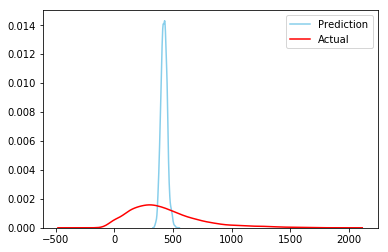

In [38]:
plotPred(regr.predict(X_train),y_train)

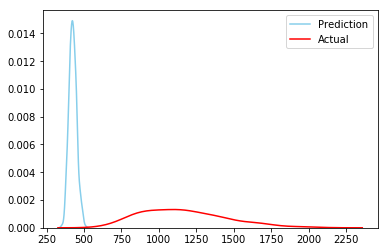

In [37]:
plotPred(y_pred,y_test)

In [ ]:
for file in os.listdir('Test/leavetimes/'):
    print('Preparing data for',file)
    df, id = dataPreparation('Test/leavetimes/'+ file)
    
    print('training data for',id)
    prepareAndTrain(df,id)

Preparing data for 27_19l
